<a href="https://colab.research.google.com/github/DavidMartinez16/Skin-Cancer-CNN/blob/master/Modelo_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**IMPORTAR LIBRERÍAS**

In [7]:
import sys
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**ACCEDER A LOS DIRECTORIOS**

In [4]:
K.clear_session()

data_train = '/content/drive/My Drive/Skin Cancer/data/train'
data_validation = '/content/drive/My Drive/Skin Cancer/data/test'

**VARIABLES**

In [16]:
width_shape = 100
height_shape = 100
num_classes = 2
epochs = 75
batch_size = 32 
# Tamaños de los filtros
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3,3)
tamano_filtro2 = (2,2)
tamano_pool = (2,2)
clases = 2
lr = 0.0005

**GENERADOR DE IMÁGENES**

In [17]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    data_train,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    data_validation,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 4084 images belonging to 2 classes.
Found 724 images belonging to 2 classes.


**CREAR LA RED NEURONAL**

In [18]:
# Red Neuronal Convolucional
cnn = Sequential()
cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', input_shape=(altura, longitud,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))
cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))
cnn.add(Flatten()) # Añade 1 dimensión que contiene toda la informacion de la CNN
cnn.add(Dense(256, activation = 'relu')) # Capa normal de la RNN
cnn.add(Dropout(0.5)) # Apaga el 50 % de las neuronas, evita sobreajuste
cnn.add(Dense(clases, activation = 'softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr), metrics =['accuracy'])

cnn.summary()
history=cnn.fit(train_generator, steps_per_epoch=(4084/batch_size), epochs=75, validation_data = validation_generator, 
                 validation_steps = (724/batch_size))



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 64)      832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 64)        16448     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 32)       

**SALVAR EL MODELO**

In [19]:
cnn.save("model_final.h5")

In [20]:
cnn.save_weights('pesos_final.h5')

**FUNCIONES PARA GRAFICAR EL ENTRENAMIENTO DE LA RED**

In [21]:
#Plot

def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)


**GRAFICAR**

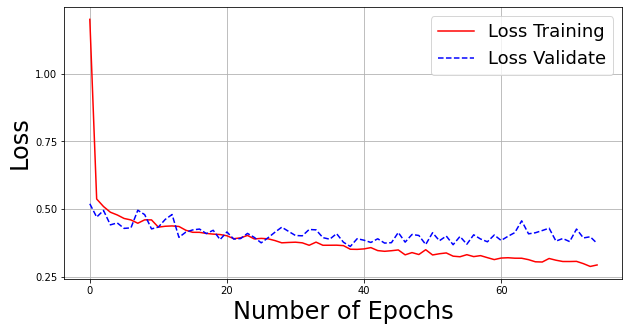

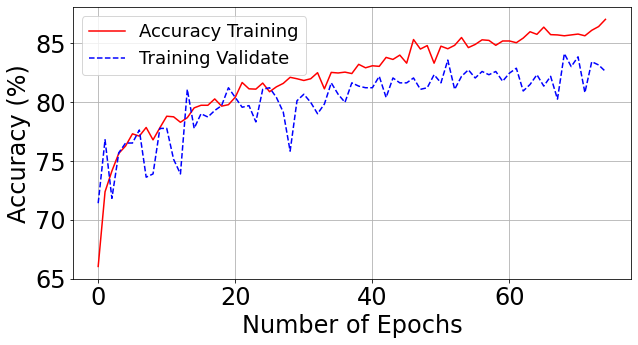

In [23]:
# Plot history

plotTraining(history,75,"loss")
plotTraining(history,75,"accuracy")
plotTraining(history,75,"val_loss")
plotTraining(history,75,"val_accuracy")

In [44]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['BENIGN','MALIGNANT']

**PREDECIR**

In [45]:
test_data_dir ='/content/drive/My Drive/Skin Cancer/data/prueba'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_final.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)


print(metrics.classification_report(y_real,y_pred, digits = 4))

Found 20 images belonging to 2 classes.
              precision    recall  f1-score   support

           0     0.5556    1.0000    0.7143        10
           1     1.0000    0.2000    0.3333        10

    accuracy                         0.6000        20
   macro avg     0.7778    0.6000    0.5238        20
weighted avg     0.7778    0.6000    0.5238        20



**MATRIZ DE CONFUSIÓN**

In [43]:
matc

array([[10,  0],
       [ 8,  2]])